# Imports 

In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
import dataframe_image as dfi
import sklearn.metrics as mtr
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.inspection import permutation_importance

pd.options.display.max_colwidth = 200

Leitura do dados

In [2]:
df = pd.read_csv("rota32893.csv")
df

,data_partida,data_chegada,linha,tempo_viagem,equipamento,dia_semana,partidaTimeStamp,qtdDiasAno,direcao,tipo_dia,turno_dia,chegadaTimeStamp,hora,hora_dia
0,2019-07-03 17:42:38,2019-07-03 18:20:59,32893,2301,1351,3,1562186558,184,2,1,3,1562188859,NaN,17
1,2019-07-05 08:53:39,2019-07-05 09:23:33,32893,1794,1353,5,1562327619,186,2,1,2,1562329413,NaN,8
2,2019-07-17 08:08:59,2019-07-17 08:47:22,32893,2303,1353,3,1563361739,198,2,1,2,1563364042,NaN,8
3,2019-07-17 11:43:09,2019-07-17 12:20:55,32893,2266,1353,3,1563374589,198,2,1,2,1563376855,NaN,11
4,2019-07-25 10:01:00,2019-07-25 10:35:59,32893,2099,1353,4,1564059660,206,2,1,2,1564061759,NaN,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5267,2019-09-29 19:47:39,2019-09-29 20:10:07,32893,1348,944,7,1569797259,272,2,1,4,1569798607,NaN,19
5268,2019-09-30 05:29:20,2019-09-30 06:18:38,32893,2958,944,1,1569832160,273,2,1,2,1569835118,NaN,5
5269,2019-09-30 07:54:52,2019-09-30 08:43:48,32893,2936,944,1,1569840892,273,2,1,2,1569843828,NaN,7
5270,2019-09-30 11:51:07,2019-09-30 12:19:58,32893,1731,944,1,1569855067,273,2,1,2,1569856798,NaN,11


# Exploração dos dados para a Escolha dos atributos

Gráfico de dispersão dos tempos de viagem ao longo dos dias

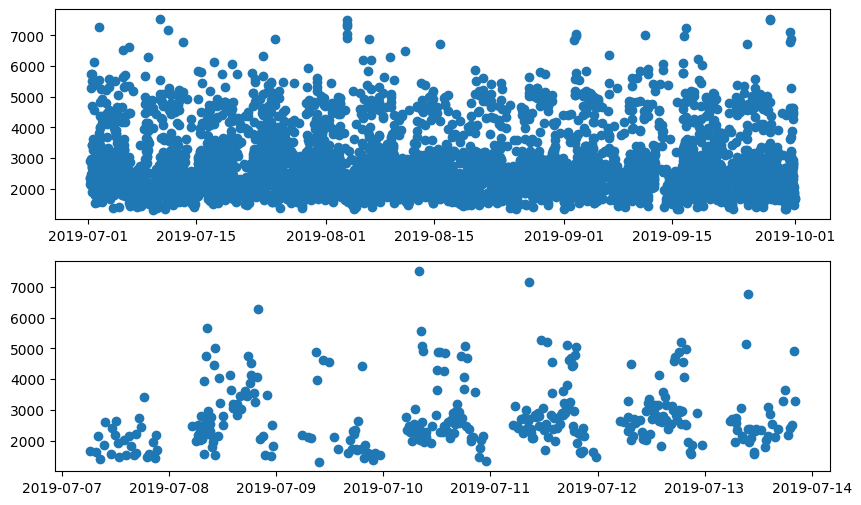

In [3]:
df.data_partida = pd.to_datetime(df.data_partida)

df_plot = df[["data_partida", "tempo_viagem"]]
df_plot = df_plot.set_index("data_partida")

plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.scatter(df_plot.index, df_plot["tempo_viagem"])

plt.subplot(2, 1, 2)
plt.scatter(df_plot[(df_plot.index > "2019-07-07") & (df_plot.index < "2019-07-14")].index, df_plot.loc[(df_plot.index > "2019-07-07") & (df_plot.index < "2019-07-14"), "tempo_viagem"])

plt.show()

Tabela de correlação entre os atributos do dataframe

In [4]:
df.corr()

C:\Users\Thiago\AppData\Local\Temp\ipykernel_2492\1134722465.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,linha,tempo_viagem,equipamento,dia_semana,partidaTimeStamp,qtdDiasAno,direcao,tipo_dia,turno_dia,chegadaTimeStamp,hora,hora_dia
linha,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tempo_viagem,NaN,1.000000,0.000933,-0.107438,-0.047102,-0.047254,NaN,-0.043944,0.011854,-0.046688,NaN,0.018935
equipamento,NaN,0.000933,1.000000,0.043130,-0.048824,-0.048510,NaN,-0.005140,-0.026185,-0.048824,NaN,-0.041909
dia_semana,NaN,-0.107438,0.043130,1.000000,-0.005862,-0.005899,NaN,0.059663,-0.000630,-0.005907,NaN,0.004323
partidaTimeStamp,NaN,-0.047102,-0.048824,-0.005862,1.000000,0.999970,NaN,-0.009222,0.041895,1.000000,NaN,0.046805
qtdDiasAno,NaN,-0.047254,-0.048510,-0.005899,0.999970,1.000000,NaN,-0.009330,0.034703,0.999970,NaN,0.039107
direcao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tipo_dia,NaN,-0.043944,-0.005140,0.059663,-0.009222,-0.009330,NaN,1.000000,0.011343,-0.009241,NaN,0.013525
turno_dia,NaN,0.011854,-0.026185,-0.000630,0.041895,0.034703,NaN,0.011343,1.000000,0.041901,NaN,0.934388
chegadaTimeStamp,NaN,-0.046688,-0.048824,-0.005907,1.000000,0.999970,NaN,-0.009241,0.041901,1.000000,NaN,0.046814


# Divisão em treino e teste

In [5]:
#Separação teste e treino
shape = int(df.shape[0] * 0.3)
df = df.sort_values(by=["data_partida"], ascending=False)
df_teste = df[:shape]
df_treino = df[shape:]

In [6]:
df_teste

,data_partida,data_chegada,linha,tempo_viagem,equipamento,dia_semana,partidaTimeStamp,qtdDiasAno,direcao,tipo_dia,turno_dia,chegadaTimeStamp,hora,hora_dia
4080,2019-09-30 23:01:36,2019-09-30 23:29:58,32893,1702,51360,1,1569895296,273,2,1,4,1569896998,NaN,23
5053,2019-09-30 22:40:17,2019-09-30 23:08:08,32893,1671,65409,1,1569894017,273,2,1,4,1569895688,NaN,22
3908,2019-09-30 22:30:04,2019-09-30 22:54:17,32893,1453,51242,1,1569893404,273,2,1,4,1569894857,NaN,22
4343,2019-09-30 21:50:20,2019-09-30 22:21:27,32893,1867,51548,1,1569891020,273,2,1,4,1569892887,NaN,21
4410,2019-09-30 21:38:06,2019-09-30 22:04:36,32893,1590,51691,1,1569890286,273,2,1,4,1569891876,NaN,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3600,2019-09-03 06:12:43,2019-09-03 06:51:46,32893,2343,1403,2,1567501963,246,2,1,2,1567504306,NaN,6
3819,2019-09-03 06:04:13,2019-09-03 06:51:09,32893,2816,51209,2,1567501453,246,2,1,2,1567504269,NaN,6
4081,2019-09-03 05:47:59,2019-09-03 06:30:14,32893,2535,51367,2,1567500479,246,2,1,2,1567503014,NaN,5
5028,2019-09-03 05:12:48,2019-09-03 05:52:33,32893,2385,64449,2,1567498368,246,2,1,2,1567500753,NaN,5


In [7]:
df_treino

,data_partida,data_chegada,linha,tempo_viagem,equipamento,dia_semana,partidaTimeStamp,qtdDiasAno,direcao,tipo_dia,turno_dia,chegadaTimeStamp,hora,hora_dia
4795,2019-09-02 22:42:36,2019-09-02 23:10:47,32893,1691,631,1,1567474956,245,2,1,4,1567476647,NaN,22
4268,2019-09-02 21:52:12,2019-09-02 22:18:29,32893,1577,51548,1,1567471932,245,2,1,4,1567473509,NaN,21
4441,2019-09-02 21:28:01,2019-09-02 21:53:47,32893,1546,51703,1,1567470481,245,2,1,4,1567472027,NaN,21
3740,2019-09-02 21:09:50,2019-09-02 21:37:09,32893,1639,50221,1,1567469390,245,2,1,4,1567471029,NaN,21
4114,2019-09-02 20:35:22,2019-09-02 21:05:00,32893,1778,51403,1,1567467322,245,2,1,4,1567469100,NaN,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,2019-07-01 07:27:18,2019-07-01 08:02:41,32893,2123,50276,1,1561976838,182,2,1,2,1561978961,NaN,7
915,2019-07-01 07:06:04,2019-07-01 07:54:36,32893,2912,52642,1,1561975564,182,2,1,2,1561978476,NaN,7
721,2019-07-01 06:47:57,2019-07-01 07:24:00,32893,2163,51888,1,1561974477,182,2,1,2,1561976640,NaN,6
118,2019-07-01 06:05:57,2019-07-01 06:45:00,32893,2343,50276,1,1561971957,182,2,1,2,1561974300,NaN,6


# Escolha dos atibutos e divisão dos atributos previsores da classe a ser prevista

Motivos das escolhas

    data_partida foi desconsiderado pois era cobrado que a data fosse int
    data_chegada e chegadaTimeStamp não fazem sentido pois nos dariam a "resposta"
    linha e equipamento são apenas identificadores e não interferem nos dados
    direcao apenas havia 1 valor (valor = 2)
    turno_dia removido pois tem alta correlação com hora_dia
    qtdDiasAno também tem uma alta correlação com os TimeStamps, mas resolvemos deixar para ver os resultados

In [8]:
x_teste = df_teste[["partidaTimeStamp", "dia_semana", "tipo_dia", "hora_dia"]]
y_teste = df_teste["tempo_viagem"]
x_treino = df_treino[["partidaTimeStamp", "dia_semana", "tipo_dia", "hora_dia"]]
y_treino = df_treino["tempo_viagem"]

# Modelagem e fit dos modelos

Possibilidades de hyper parâmetros para os modelos que serão criados

In [9]:
# Hyperparâmetros do XGBoosting
params_xgb = {
         "n_estimators": list(range(100, 1100, 100)), #Number of gradient boosted trees. Equivalent to number of boosting rounds
         "max_depth": list(range(2, 15)),#Maximum tree depth for base learners.
         "min_child_weight": list(range(1, 11)),#Minimum sum of instance weight(hessian) needed in a child.
         "learning_rate": [0.3, 0.2, 0.1, 0.05, 0.01, 0.005],#Boosting learning rate (xgb’s “eta”)
         "gamma": np.arange(0, 0.7, 0.1)#Minimum loss reduction required to make a further partition on a leaf node of the tree.
        }

# Hyperparâmetros do Random Forest
params_rf = {
         "n_estimators": list(range(100, 1100, 100)),#The number of trees in the forest.
         "bootstrap": [True, False],#Whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree.
         "max_depth": list(range(2, 15)),#The maximum depth of the tree.
         "max_features": [1.0, "sqrt", "log2"],#The number of features to consider when looking for the best split:
         "min_samples_leaf": list(range(1, 11)),#The minimum number of samples required to split an internal node
         "min_samples_split": list(range(2, 11)),#The minimum number of samples required to be at a leaf node.
        }

# Hyperparâmetros do SVR
params_svr = {
         "C": [0.1, 1, 10, 100, 1000], #Regularization parameter. The strength of the regularization is inversely proportional to C
         "gamma": ["scale", "auto"],#Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.
        }

#Linear Regression não tem hyper parametrização

In [10]:
#Criação e fit do modelo XGB
modelo_xgb = xgb.XGBRegressor(early_stop_rounds = 100)
xgb_rand_search = RandomizedSearchCV(modelo_xgb, params_xgb, scoring="neg_mean_squared_error", n_iter=40, verbose=True, cv=10, n_jobs=-1, random_state=123)
xgb_rand_search.fit(x_treino, y_treino)
modelo_xgb = xgb_rand_search.best_estimator_

pprint(xgb_rand_search.best_params_)
modelo_xgb.fit(x_treino, y_treino, eval_set = [(x_treino, y_treino)])

Fitting 10 folds for each of 40 candidates, totalling 400 fits
[17:39:11] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "early_stop_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


{'gamma': 0.0,
 'learning_rate': 0.005,
 'max_depth': 3,
 'min_child_weight': 5,
 'n_estimators': 900}
[17:39:12] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "early_stop_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find 

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stop_rounds=100, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=0.0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.005, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=3, max_leaves=0,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=900, n_jobs=0, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=0, ...)

In [11]:
#Criação e fit do modelo XGB
modelo_rf = RandomForestRegressor()
rf_rand_search = RandomizedSearchCV(modelo_rf, params_rf, scoring="neg_mean_squared_error", n_iter=40, verbose=True, cv=10, n_jobs=-1, random_state=123)
rf_rand_search.fit(x_treino, y_treino)
modelo_rf = rf_rand_search.best_estimator_

pprint(rf_rand_search.best_params_)
modelo_rf.fit(x_treino, y_treino)

Fitting 10 folds for each of 40 candidates, totalling 400 fits
{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 8,
 'min_samples_split': 5,
 'n_estimators': 700}


RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=8,
                      min_samples_split=5, n_estimators=700)

In [12]:
#Criação e fit do modelo XGB
modelo_svr = SVR(kernel = 'rbf')
svr_rand_search = RandomizedSearchCV(modelo_svr, params_svr, scoring="neg_mean_squared_error", n_iter=10, verbose=True, cv=10, n_jobs=-1, random_state=123)
svr_rand_search.fit(x_treino, y_treino)
modelo_svr = svr_rand_search.best_estimator_

pprint(svr_rand_search.best_params_)
modelo_svr.fit(x_treino, y_treino)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
{'C': 1000, 'gamma': 'auto'}


SVR(C=1000, gamma='auto')

In [13]:
#Criação e fit do modelo XGB
modelo_lr = LinearRegression()
modelo_lr.fit(x_treino, y_treino)

LinearRegression()

# Métricas 

Importância dos atributos

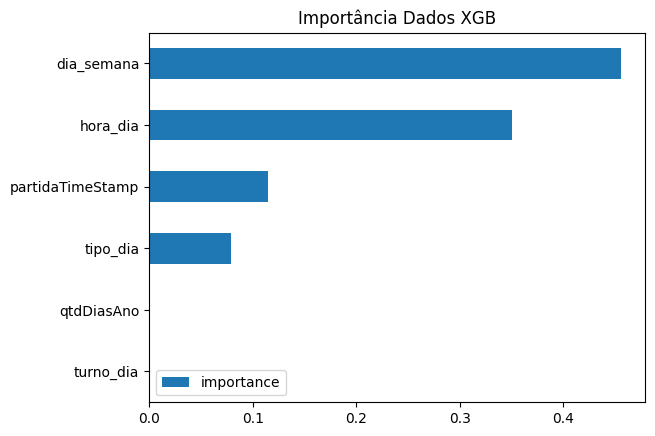

In [14]:
fi_xgb = pd.DataFrame(data=modelo_xgb.feature_importances_, index=modelo_xgb.feature_names_in_, columns=["importance"])
fi_xgb.sort_values("importance").plot(kind="barh", title="Importância Dados XGB")
plt.savefig('Images/FeatureImportance/fi_XGB_32893.jpg')

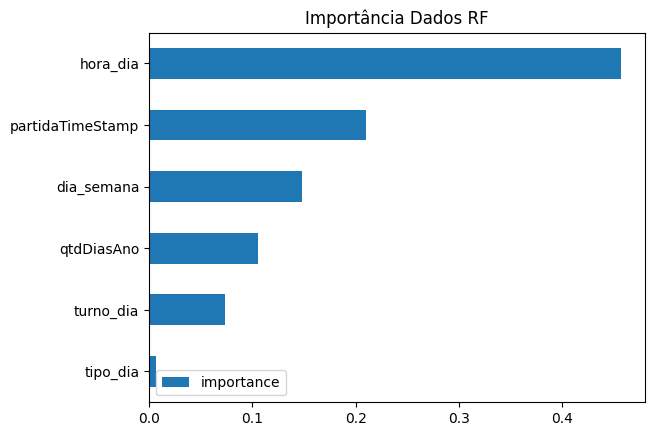

In [15]:
fi_rf = pd.DataFrame(data=modelo_rf.feature_importances_, index=x_treino.columns, columns=["importance"])
fi_rf.sort_values("importance").plot(kind="barh", title="Importância Dados RF")
plt.savefig('Images/FeatureImportance/fi_RF_32893.jpg')

In [16]:
#Feature importance do SVR, duvidoso e sem os nomes
# results = permutation_importance(modelo_svr, x_treino, y_treino, scoring='neg_mean_squared_error')
# print(f'Result: {results}')
# importance = results.importances_mean
# print(f'Importance: {importance}')
# for i,v in enumerate(importance):
#     print('Feature: %0d, Score: %.5f' % (x_treino.columns[i],v)) # Duvidoso, não sabemos a onde das colunas
# plt.bar([x for x in range(len(importance))], importance)

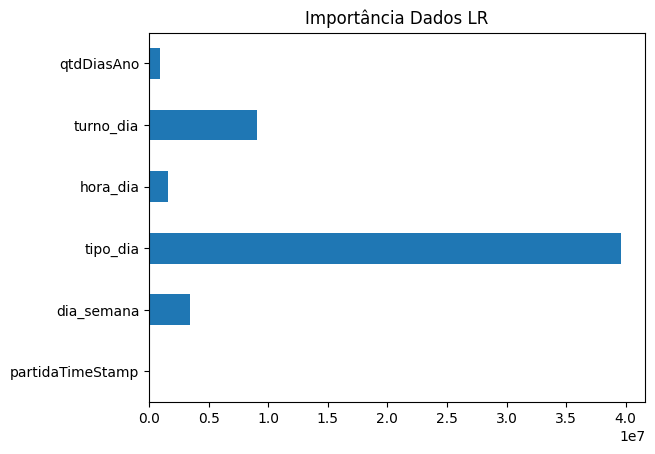

In [17]:
coefs_lr = pd.DataFrame(modelo_lr.coef_, columns=['Coeficiente'], index = x_treino.columns)
coefs_lr.Coeficiente = coefs_lr.Coeficiente.abs()
coefs_lr['DesvioPadrão'] = x_treino.std(axis=0)
coefs_lr['Importancia'] = (100*coefs_lr['DesvioPadrão']*coefs_lr['Coeficiente'])/coefs_lr['DesvioPadrão']*coefs_lr['Coeficiente'].max()
coefs_lr['Importancia'].plot(kind='barh', title = 'Importância Dados LR')
plt.savefig('Images/FeatureImportance/fi_LR_32893.jpg')

Junção das previsões no dataframe de teste

In [18]:
df_teste["predicao_xgb"] = modelo_xgb.predict(x_teste)
df_teste["predicao_lr"] = modelo_lr.predict(x_teste)
df_teste["predicao_rf"] = modelo_rf.predict(x_teste)
df_teste["predicao_svr"] = modelo_svr.predict(x_teste)
df_teste

C:\Users\Thiago\AppData\Local\Temp\ipykernel_2492\1728344419.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste["predicao_xgb"] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_2492\1728344419.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste["predicao_lr"] = modelo_lr.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_2492\1728344419.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

,data_partida,data_chegada,linha,tempo_viagem,equipamento,dia_semana,partidaTimeStamp,qtdDiasAno,direcao,tipo_dia,turno_dia,chegadaTimeStamp,hora,hora_dia,predicao_xgb,predicao_lr,predicao_rf,predicao_svr
4080,2019-09-30 23:01:36,2019-09-30 23:29:58,32893,1702,51360,1,1569895296,273,2,1,4,1569896998,NaN,23,1716.796387,2747.035936,1938.445800,2606.471314
5053,2019-09-30 22:40:17,2019-09-30 23:08:08,32893,1671,65409,1,1569894017,273,2,1,4,1569895688,NaN,22,1822.618652,2721.946104,1971.646283,2606.471314
3908,2019-09-30 22:30:04,2019-09-30 22:54:17,32893,1453,51242,1,1569893404,273,2,1,4,1569894857,NaN,22,1822.618652,2722.080759,1971.646283,2606.471314
4343,2019-09-30 21:50:20,2019-09-30 22:21:27,32893,1867,51548,1,1569891020,273,2,1,4,1569892887,NaN,21,1822.618652,2697.233658,1959.689948,2606.471314
4410,2019-09-30 21:38:06,2019-09-30 22:04:36,32893,1590,51691,1,1569890286,273,2,1,4,1569891876,NaN,21,1822.618652,2697.394894,1959.689948,2606.471314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3600,2019-09-03 06:12:43,2019-09-03 06:51:46,32893,2343,1403,2,1567501963,246,2,1,2,1567504306,NaN,6,2808.860840,2664.525778,3185.640264,2606.471314
3819,2019-09-03 06:04:13,2019-09-03 06:51:09,32893,2816,51209,2,1567501453,246,2,1,2,1567504269,NaN,6,2808.860840,2664.637808,3185.640264,2606.471314
4081,2019-09-03 05:47:59,2019-09-03 06:30:14,32893,2535,51367,2,1567500479,246,2,1,2,1567503014,NaN,5,2601.530518,2639.480977,3005.556505,2606.471314
5028,2019-09-03 05:12:48,2019-09-03 05:52:33,32893,2385,64449,2,1567498368,246,2,1,2,1567500753,NaN,5,2601.530518,2639.944693,3005.556505,2606.471314


Cálculo das métricas

In [19]:
RRSE_xgb = np.sqrt(sum((df_teste["tempo_viagem"] - df_teste["predicao_xgb"]) ** 2) / sum((df_teste["tempo_viagem"] - np.mean(df_teste["tempo_viagem"])) ** 2))
RMSE_xgb = mtr.mean_squared_error(df_teste["tempo_viagem"], df_teste["predicao_xgb"], squared=False) 
MAPE_xgb = mtr.mean_absolute_percentage_error(df_teste["tempo_viagem"], df_teste["predicao_xgb"])

RRSE_rf = np.sqrt(sum((df_teste["tempo_viagem"] - df_teste["predicao_rf"]) ** 2) / sum((df_teste["tempo_viagem"] - np.mean(df_teste["tempo_viagem"])) ** 2))
RMSE_rf = mtr.mean_squared_error(df_teste["tempo_viagem"], df_teste["predicao_rf"], squared=False) 
MAPE_rf = mtr.mean_absolute_percentage_error(df_teste["tempo_viagem"], df_teste["predicao_rf"])

RRSE_svr = np.sqrt(sum((df_teste["tempo_viagem"] - df_teste["predicao_svr"]) ** 2) / sum((df_teste["tempo_viagem"] - np.mean(df_teste["tempo_viagem"])) ** 2))
RMSE_svr = mtr.mean_squared_error(df_teste["tempo_viagem"], df_teste["predicao_svr"], squared=False) 
MAPE_svr = mtr.mean_absolute_percentage_error(df_teste["tempo_viagem"], df_teste["predicao_svr"])

RRSE_lr = np.sqrt(sum((df_teste["tempo_viagem"] - df_teste["predicao_lr"]) ** 2) / sum((df_teste["tempo_viagem"] - np.mean(df_teste["tempo_viagem"])) ** 2))
RMSE_lr = mtr.mean_squared_error(df_teste["tempo_viagem"], df_teste["predicao_lr"], squared=False) 
MAPE_lr = mtr.mean_absolute_percentage_error(df_teste["tempo_viagem"], df_teste["predicao_lr"])

metrics = pd.DataFrame(np.array([
        [RRSE_xgb, RRSE_rf, RRSE_svr, RRSE_lr, x_teste.columns.values],
        [RMSE_xgb, RMSE_rf, RMSE_svr, RMSE_lr, x_teste.columns.values],
        [MAPE_xgb, MAPE_rf, MAPE_svr, MAPE_lr, x_teste.columns.values]
    ]),columns=['XGBoosting','Random Forest','Support Vector Regression','Linear Regression', 'Colunas'], index=['RRSE','RMSE', 'MAPE'])
metrics

C:\Users\Thiago\AppData\Local\Temp\ipykernel_2492\309749487.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  metrics = pd.DataFrame(np.array([


,XGBoosting,Random Forest,Support Vector Regression,Linear Regression,Colunas
RRSE,0.977484,1.026644,1.008382,1.010703,"[partidaTimeStamp, dia_semana, tipo_dia, hora_dia, turno_dia, qtdDiasAno]"
RMSE,915.544459,961.590245,944.485078,946.65915,"[partidaTimeStamp, dia_semana, tipo_dia, hora_dia, turno_dia, qtdDiasAno]"


In [20]:
dfi.export(metrics, "Images/Metrics/metrics_32893.jpg")

In [ ]:
plt.style.use("fivethirtyeight")
 
plt.figure(figsize=(20, 10))
 
plt.xlabel("Data")
plt.ylabel("Tempo Viagem")
plt.title("Tempo Viagem Real x Tempo Viagem Predição")

df_plot_predicao = df_teste[(df_teste["data_partida"] > "2019-09-15") & (df_teste["data_partida"] < "2019-09-21")]

plt.plot(df_plot_predicao["data_partida"], df_plot_predicao["tempo_viagem"], color="#1f77b4", label="Real")
plt.plot(df_plot_predicao["data_partida"], df_plot_predicao["predicao_xgb"], color="#ff7f0e", label="XGB")
plt.plot(df_plot_predicao["data_partida"], df_plot_predicao["predicao_svr"], color="#2ca02c", label="SVR")
plt.plot(df_plot_predicao["data_partida"], df_plot_predicao["predicao_rf"], color="#d62728", label="RF")
plt.plot(df_plot_predicao["data_partida"], df_plot_predicao["predicao_lr"], color="#9467bd", label="LR")
plt.legend()

plt.savefig("Images/Results/32893_line_charth.jpg")